# London Smart meters dataset

https://data.london.gov.uk/dataset/smartmeter-energy-use-data-in-london-households

In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

In [2]:
DATASET_ID = 0 # 'FULL'
DECIMATION_RATE = 0.1 # valid only if dataset is FULL

In [3]:
def diff_min( s : pd.Series ) -> float :
    return s.diff().min()

def diff_max( s : pd.Series ) -> float :
    return s.diff().max()

def q25( s : pd.Series ) -> float :
    return s.quantile( 0.25 )

def q50( s : pd.Series ) -> float :
    return s.quantile( 0.50 )

def q75( s : pd.Series ) -> float :
    return s.quantile( 0.75 )

In [4]:
dataset_root = Path('../../Dataset')

In [5]:
if isinstance( DATASET_ID, int )  :
    dataset = sorted(list((dataset_root/'partitioned/Small LCL Data').glob('*.csv')))[ DATASET_ID ]
else :
    dataset = dataset_root/'full/CC_LCL-FullData.csv'

In [6]:
%%time
df = pd.read_csv(dataset, names = ['ID','type','timestamp','consumption'], header = 0) 

CPU times: user 450 ms, sys: 19.4 ms, total: 469 ms
Wall time: 469 ms


In [7]:
ids = df.ID.unique()
if not isinstance( DATASET_ID, int )  :
    ids = np.random.choice( ids, int( len(ids) * DECIMATION_RATE ) )
    df = df.query( 'ID in @ids' )

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   ID           1000000 non-null  object
 1   type         1000000 non-null  object
 2   timestamp    1000000 non-null  object
 3   consumption  1000000 non-null  object
dtypes: object(4)
memory usage: 30.5+ MB


In [9]:
%%time
df = (df
      .assign( timestamp = pd.to_datetime(df.timestamp) )
      .assign( consumption = pd.to_numeric( df.consumption, errors = 'coerce' ) )
      .assign( invalid = lambda x : x.consumption.isna() )
#      .assign( consumption = lambda x : x.consumption.fillna( -1.0 ) )
    )
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 5 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   ID           1000000 non-null  object        
 1   type         1000000 non-null  object        
 2   timestamp    1000000 non-null  datetime64[ns]
 3   consumption  999971 non-null   float64       
 4   invalid      1000000 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(1), object(2)
memory usage: 31.5+ MB
CPU times: user 390 ms, sys: 28.9 ms, total: 419 ms
Wall time: 417 ms


In [10]:
%%time
df_features = (  df
                 .set_index('timestamp')
                 .groupby('ID')
                 .resample('M')
                 .agg({'consumption': ['min', 'max', 'mean', 'std', diff_min, diff_max, q25, q50, q75, 'count'], 'invalid': 'sum'})
                 .droplevel( 0, axis = 1 )
                 .rename( columns = {'sum':'count_nan'} )
                 .assign( sample_name = lambda x : [f'{i[0]}-{str(i[1].date())}' for i in x.index] )
                 .set_index( 'sample_name' )
                )


CPU times: user 1.62 s, sys: 14.9 ms, total: 1.63 s
Wall time: 1.63 s


In [11]:
df_features

,min,max,mean,std,diff_min,diff_max,q25,q50,q75,count,count_nan
sample_name,,,,,,,,,,,
MAC000002-2012-10-31,0.000,2.160,0.289620,0.255436,-1.331,1.034,0.122,0.1940,0.3755,959,0
MAC000002-2012-11-30,0.071,1.714,0.247859,0.201822,-1.127,1.008,0.126,0.1970,0.2730,1392,0
MAC000002-2012-12-31,0.069,1.692,0.239087,0.210911,-1.182,1.185,0.112,0.1695,0.2680,1488,1
MAC000002-2013-01-31,0.071,1.603,0.241828,0.212572,-1.250,1.077,0.116,0.1970,0.2630,1489,0
MAC000002-2013-02-28,0.065,2.994,0.283894,0.311073,-1.679,1.983,0.113,0.1890,0.2760,1345,0
...,...,...,...,...,...,...,...,...,...,...,...
MAC000036-2012-07-31,0.000,0.384,0.058546,0.062646,-0.314,0.331,0.014,0.0450,0.0700,1489,0
MAC000036-2012-08-31,0.000,0.458,0.063178,0.066233,-0.405,0.458,0.021,0.0490,0.0760,1489,0
MAC000036-2012-09-30,0.000,0.427,0.057057,0.058898,-0.362,0.427,0.014,0.0450,0.0700,1441,0


In [12]:
%%time
df_series = (  df
               .assign( year = df.timestamp.dt.year.astype( str ) )
               .assign( month = df.timestamp.dt.month.apply( lambda d : f'{d:02d}' ) ) 
               .assign( day = df.timestamp.dt.day.apply( lambda d : f'{d:02d}' ) ) 
               .assign( time = df.timestamp.dt.time.astype( str ) )
               .assign( year_month = lambda x : x.year.str.cat( x.month, sep = '-' ) )
               .assign( day_time = lambda x : x.day.str.cat( x.time, sep = '-' ) )
               .assign( sample_name = lambda x : x.ID.str.cat( x.year_month, sep = '-' ) )
               [['sample_name','day_time','consumption']]
               .groupby( ['sample_name','day_time'] )
               .sum()
               .unstack( 'day_time' )             
            )


CPU times: user 3.08 s, sys: 256 ms, total: 3.34 s
Wall time: 3.34 s


In [13]:
df_series

consumption                                                  \
day_time          01-00:00:00 01-00:30:00 01-01:00:00 01-01:30:00 01-02:00:00   
sample_name                                                                     
MAC000002-2012-10         NaN         NaN         NaN         NaN         NaN   
MAC000002-2012-11       0.252       0.241       0.230       0.209       0.231   
MAC000002-2012-12       0.215       0.217       0.237       0.204       0.243   
MAC000002-2013-01       0.219       0.241       0.191       0.235       0.182   
MAC000002-2013-02       0.215       0.284       0.313       0.286       0.204   
...                       ...         ...         ...         ...         ...   
MAC000036-2012-07       0.000       0.055       0.029       0.000       0.033   
MAC000036-2012-08       0.000       0.063       0.015       0.000       0.045   
MAC000036-2012-09       0.000       0.045       0.031       0.000       0.016   
MAC000036-2012-10       0.006       0.006       0.052       0.037       0.006   
MAC000036-2012-11       0.060       0.006       0.006       0.019       0.063   

                                                                               \
day_time          01-02:30:00 01-03:00:00 01-03:30:00 01-04:00:00 01-04:30:00   
sample_name                                                                     
MAC000002-2012-10         NaN         NaN         NaN         NaN         NaN   
MAC000002-2012-11       0.193       0.186       0.148       0.183       0.147   
MAC000002-2012-12       0.199       0.237       0.125       0.104       0.115   
MAC000002-2013-01       0.229       0.194       0.201       0.122       0.099   
MAC000002-2013-02       0.269       0.204       0.266       0.216       0.223   
...                       ...         ...         ...         ...         ...   
MAC000036-2012-07       0.050       0.000       0.011       0.065       0.006   
MAC000036-2012-08       0.033       0.000       0.024       0.052       0.000   
MAC000036-2012-09       0.060       0.000       0.000       0.055       0.019   
MAC000036-2012-10       0.006       0.055       0.033       0.006       0.006   
MAC000036-2012-11       0.000       0.000       0.006       0.066       0.006   

                   ...                                                  \
day_time           ... 31-19:00:00 31-19:30:00 31-20:00:00 31-20:30:00   
sample_name        ...                                                   
MAC000002-2012-10  ...       0.346       0.291       0.333       0.368   
MAC000002-2012-11  ...         NaN         NaN         NaN         NaN   
MAC000002-2012-12  ...       0.227       0.228       1.168       0.272   
MAC000002-2013-01  ...       0.194       0.214       1.078       0.227   
MAC000002-2013-02  ...         NaN         NaN         NaN         NaN   
...                ...         ...         ...         ...         ...   
MAC000036-2012-07  ...       0.039       0.095       0.064       0.043   
MAC000036-2012-08  ...       0.044       0.094       0.065       0.050   
MAC000036-2012-09  ...         NaN         NaN         NaN         NaN   
MAC000036-2012-10  ...       0.044       0.073       0.092       0.188   
MAC000036-2012-11  ...         NaN         NaN         NaN         NaN   

                                                                               \
day_time          31-21:00:00 31-21:30:00 31-22:00:00 31-22:30:00 31-23:00:00   
sample_name                                                                     
MAC000002-2012-10       0.951       1.445       0.946       0.305       0.243   
MAC000002-2012-11         NaN         NaN         NaN         NaN         NaN   
MAC000002-2012-12       0.237       0.231       0.263       0.220       0.236   
MAC000002-2013-01       0.250       0.240       0.281       0.248       0.266   
MAC000002-2013-02         NaN         NaN         NaN         NaN         NaN   
...                       ...         ...         ...         .

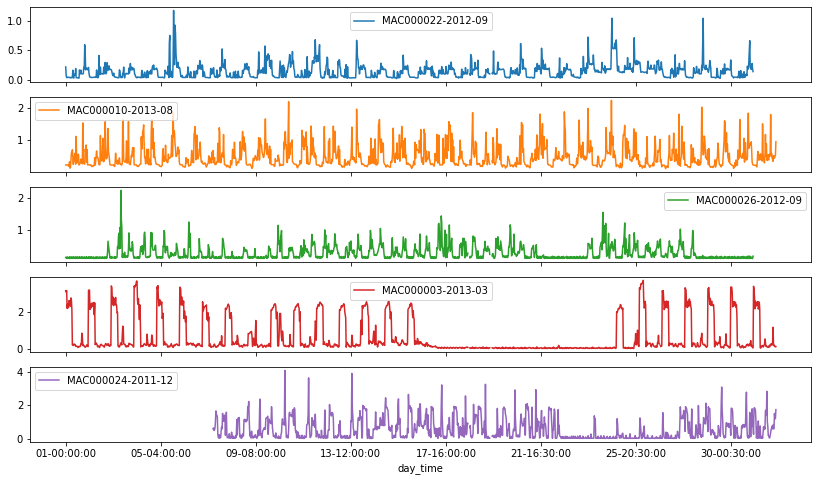

In [14]:
df_series.sample(5).T.droplevel(0).plot( figsize = (14,8), subplots = True )
plt.show()

# Save ingested data

In [15]:
if isinstance( DATASET_ID, int )  :
    out_file_series = f'ingested/series_{DATASET_ID}.csv' 
    out_file_features = f'ingested/features_{DATASET_ID}.csv' 
else :
    out_file_series = f'ingested/series_full_{DECIMATION_RATE}.csv' 
    out_file_features = f'ingested/features_full_{DECIMATION_RATE}.csv' 
    
df_series.to_csv( dataset_root/out_file_series )
print(f'Series dataframe saved to {dataset_root/out_file_series}')

df_features.to_csv( dataset_root/out_file_features )
print(f'Features dataframe saved to {dataset_root/out_file_features}')


Series dataframe saved to ../../Dataset/ingested/series_0.csv
Features dataframe saved to ../../Dataset/ingested/features_0.csv
